In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from functools import partial
from skimage.measure import ransac

%matplotlib inline


# SLAM!

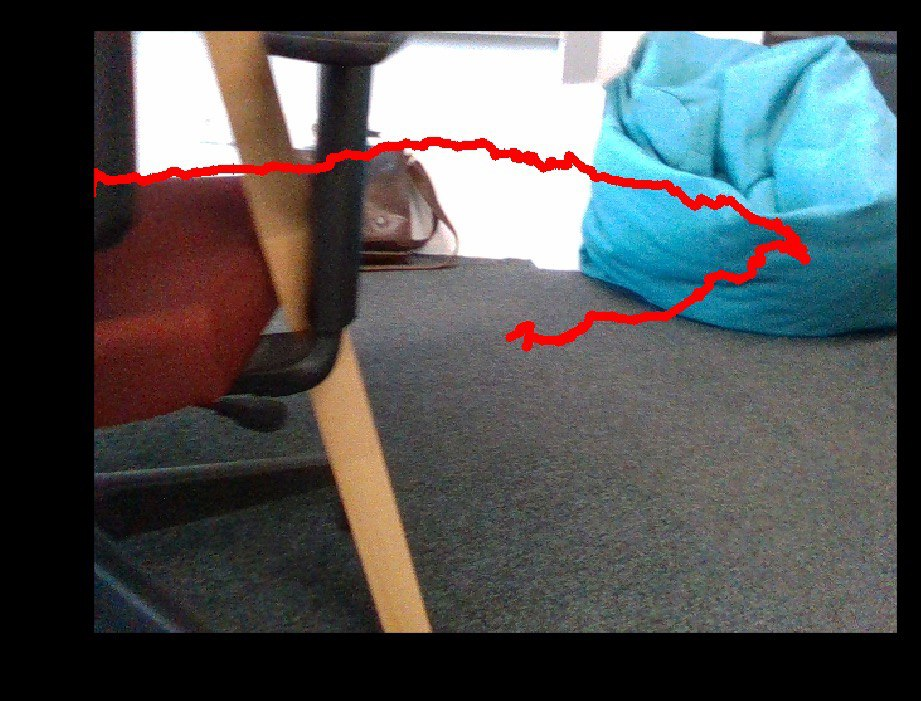

# Reading dataset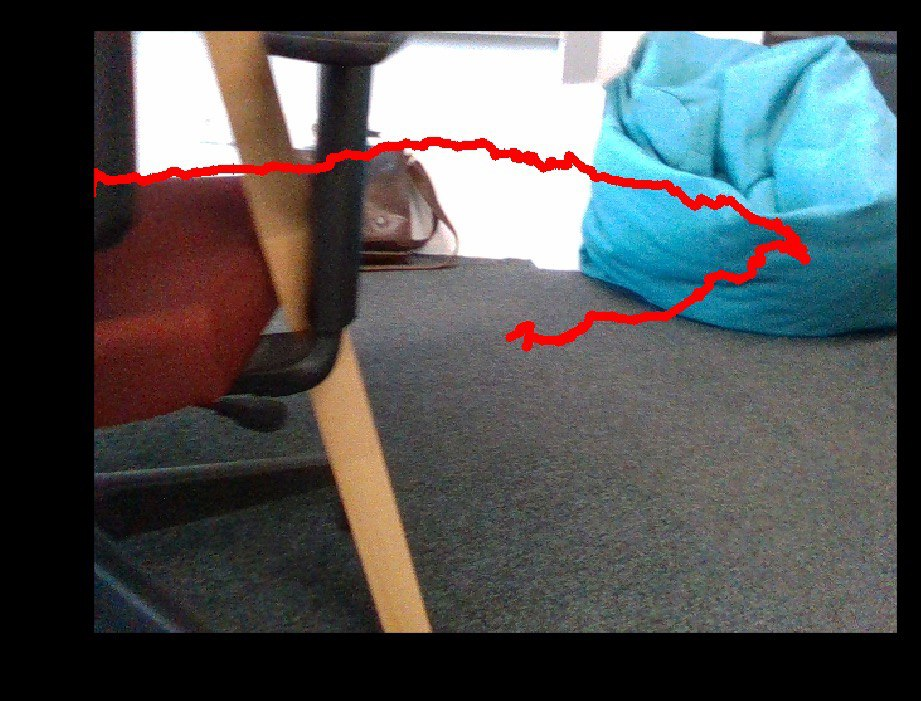

https://disk.yandex.ru/d/nNrs_lRpEmchMQ

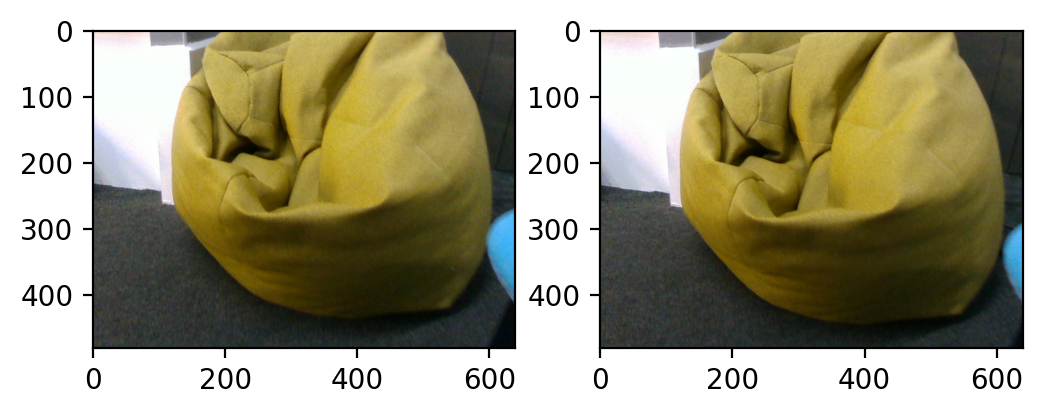

In [2]:
base_i = 270
base_i2 = 300

base_i = 205
base_i2 = 206

#300, 312
def get_im_names(numbers, base_path="/Users/anton/Downloads/slam_dataset/captured/", depth=False):
    im_type = "color_" if not depth else "depth"
    return [os.path.join(base_path, f"{im_type}{n}.png") for n in numbers]

plt.figure(dpi=200)
for n, im in enumerate(get_im_names([base_i, base_i2])):
    im  = cv2.imread(im)[:,:,::-1]
    plt.subplot(1,2,n+1)
    plt.imshow(im)

### What is depth

Cutie realsense d435

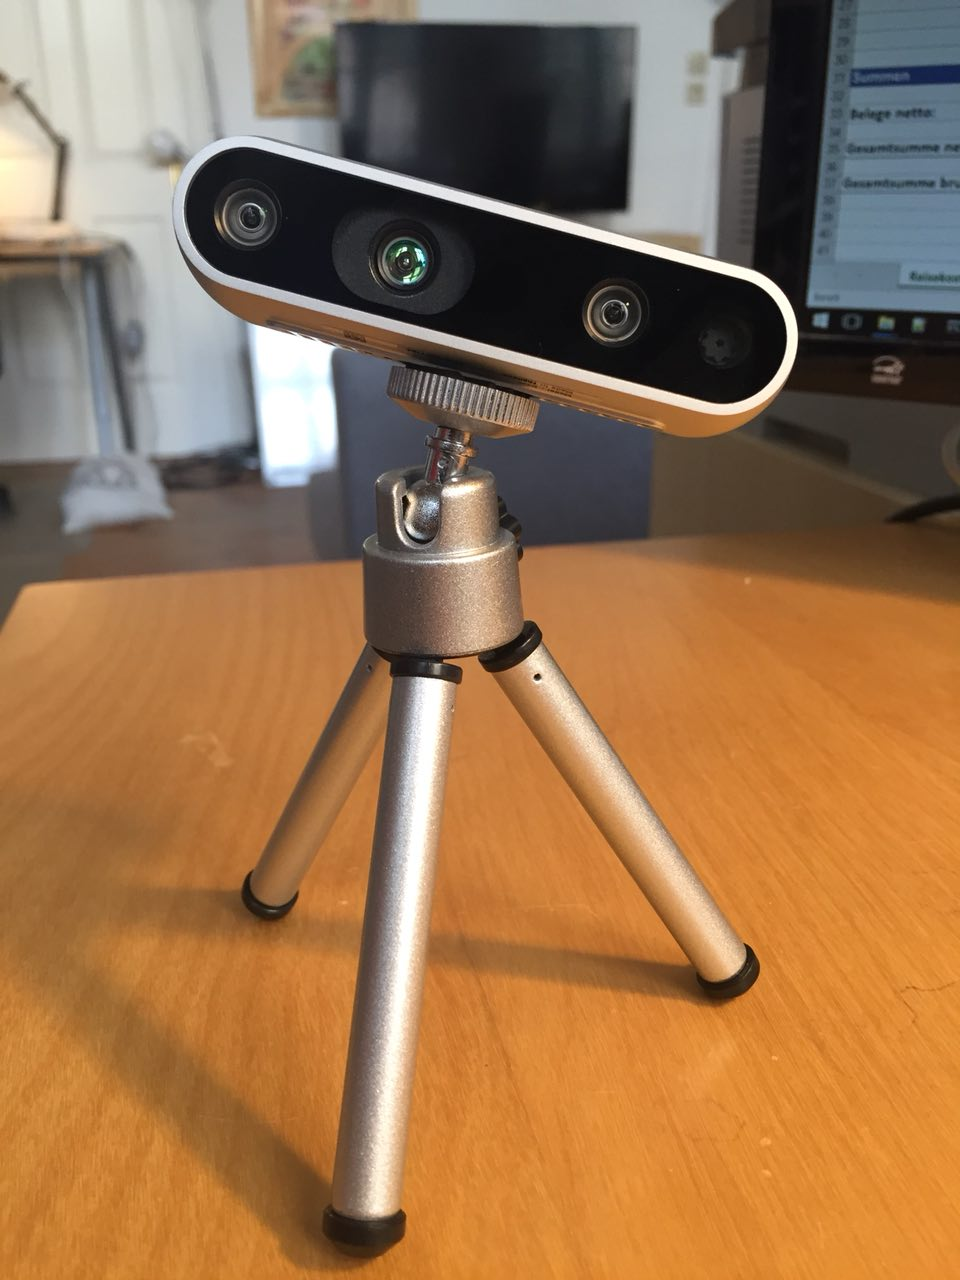

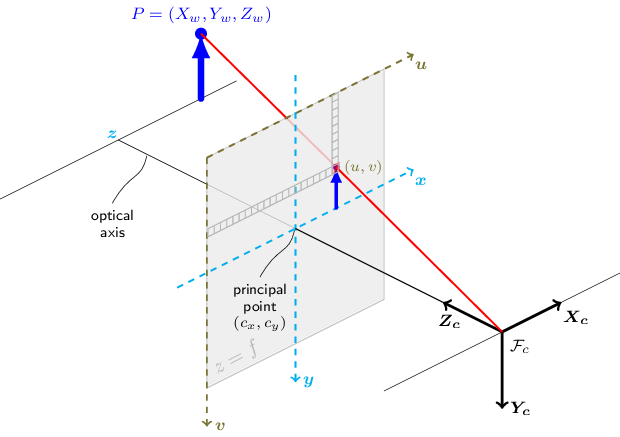

## Kinds of depth cameras:

### 1. Structured lighting

![img](https://i.ytimg.com/vi/CIkscN6nXcE/maxresdefault.jpg)

![img](https://ars.els-cdn.com/content/image/1-s2.0-S0263224115001888-gr1.jpg)

## 2. Stereo Camera

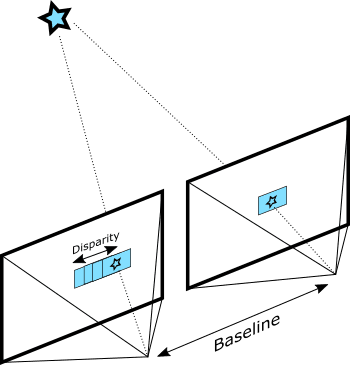

![img](https://www.e-consystems.com/images/See3cam/See3CAM_Stereo/tara-stereo-camera-usb3.0.JPG)

## 3. Time of Flight  (ToF)

![img](https://www.dignited.com/wp-content/uploads/2020/10/LiDAR-Scanner-1.png)

http://ericstockmeyer.com/iphone-x-depth-data-experiments/

https://www.youtube.com/watch?v=UBu2KrjFEuw

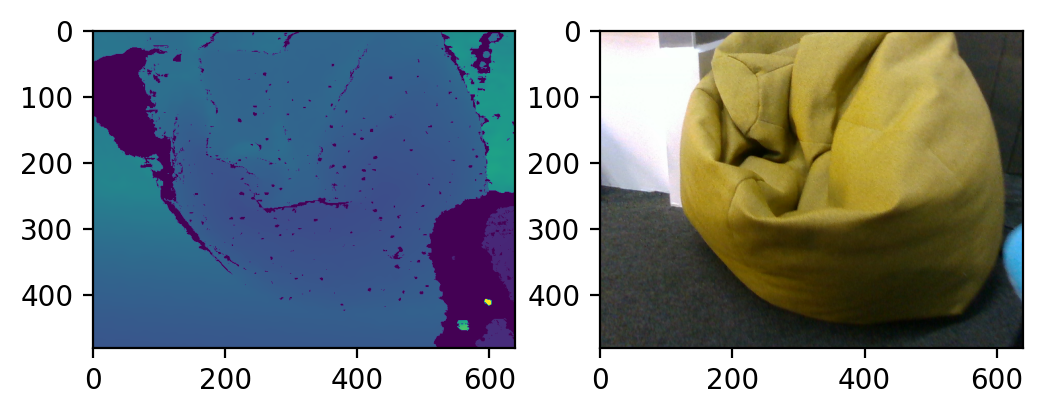

In [5]:
depth = cv2.imread( get_im_names([base_i], depth=True)[0],  flags=cv2.IMREAD_UNCHANGED)
plt.figure(dpi=200)
plt.subplot(1,2,1)
plt.imshow(depth)
plt.subplot(1,2,2)
plt.imshow(im)

In [6]:
depth.dtype

dtype('uint16')

In [7]:
img1, img2 = map(cv2.imread, get_im_names([base_i, base_i2]))

# Solving the problem. We need to match keypoints.

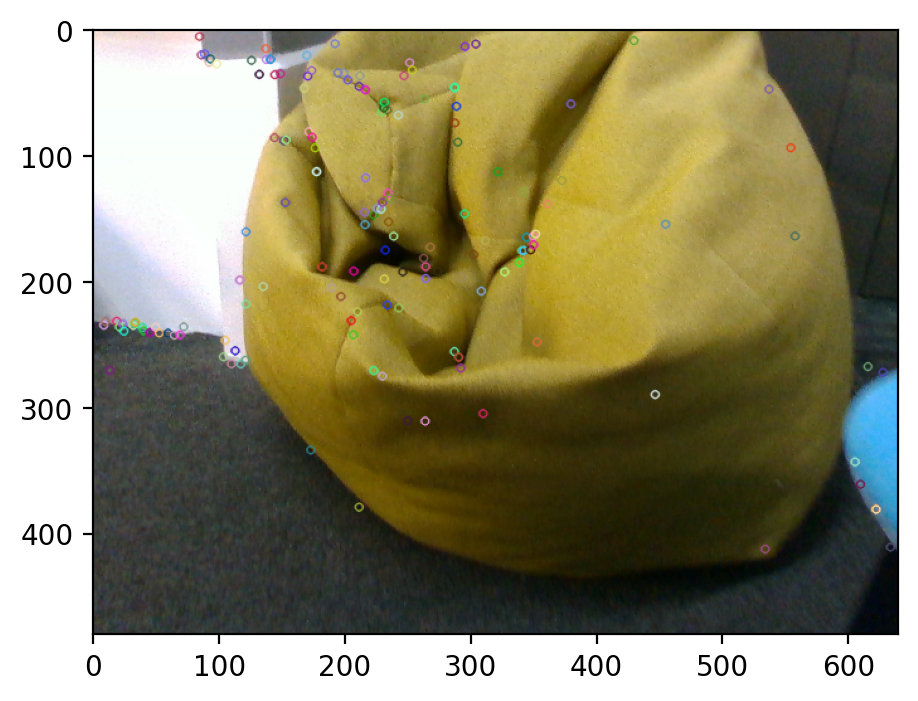

In [8]:
sift = cv2.SIFT_create()
keypoints_sift, descriptors = sift.detectAndCompute(img1, None)
im_ = cv2.drawKeypoints(img1, keypoints_sift, None)
plt.figure(dpi=200)
plt.imshow(im_[:,:,::-1])

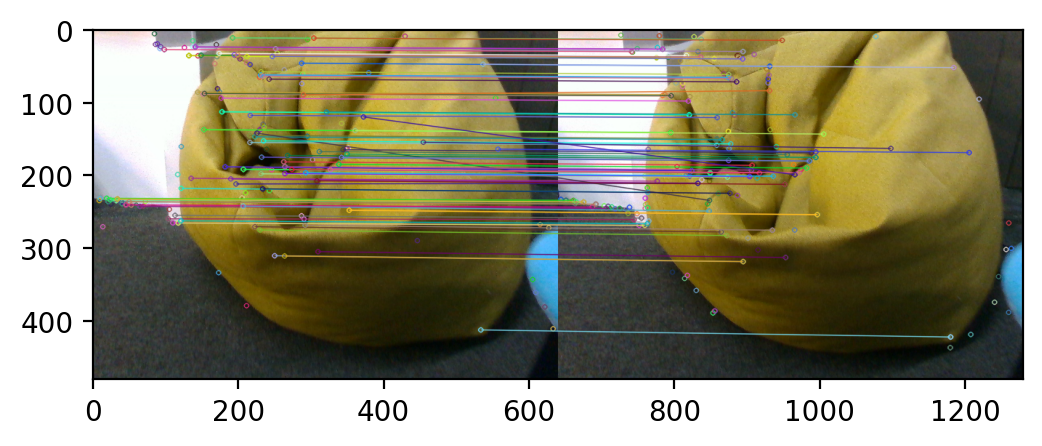

In [66]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)


# BFMatcher with default params
bf = cv2.BFMatcher()

matches = bf.knnMatch(des1, des2, k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
plt.figure(dpi=200)
plt.imshow(img3[:,:,::-1])

In [67]:
def get_pair_point(img1, img2):
    sift = cv2.xfeatures2d.SIFT_create()
    cv2.xfeatures2d.SIFT_create
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    # Apply ratio test
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            yield kp1[m.queryIdx].pt, kp2[m.trainIdx].pt

point_pairs = list(get_pair_point(img1,img2))

In [36]:
with open("camera_matrix.json") as f:
    camera_matrix = json.load(f)
camera_matrix = np.array(camera_matrix)

def get_world_coords(x,y, depth, camera_matrix=camera_matrix):
    """return physical coordinates in mm
    
    Keyword arguments:
    x, y -- coordinates of a point in pixels
    depth -- depth coordiante of the same point
    camera_matrix -- 3x3 matrix with focal lengthes and principial point"""
    f = np.linalg.inv(camera_matrix)
    v = np.array([x,y,1]) * depth
    return np.dot(f,v)

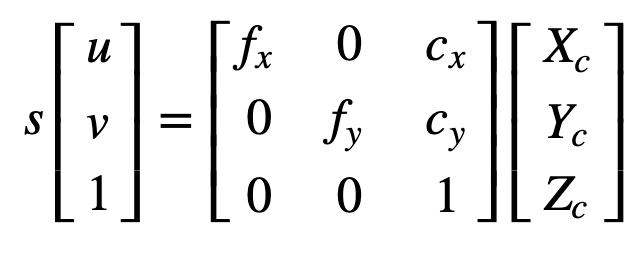

# Viewing depth image

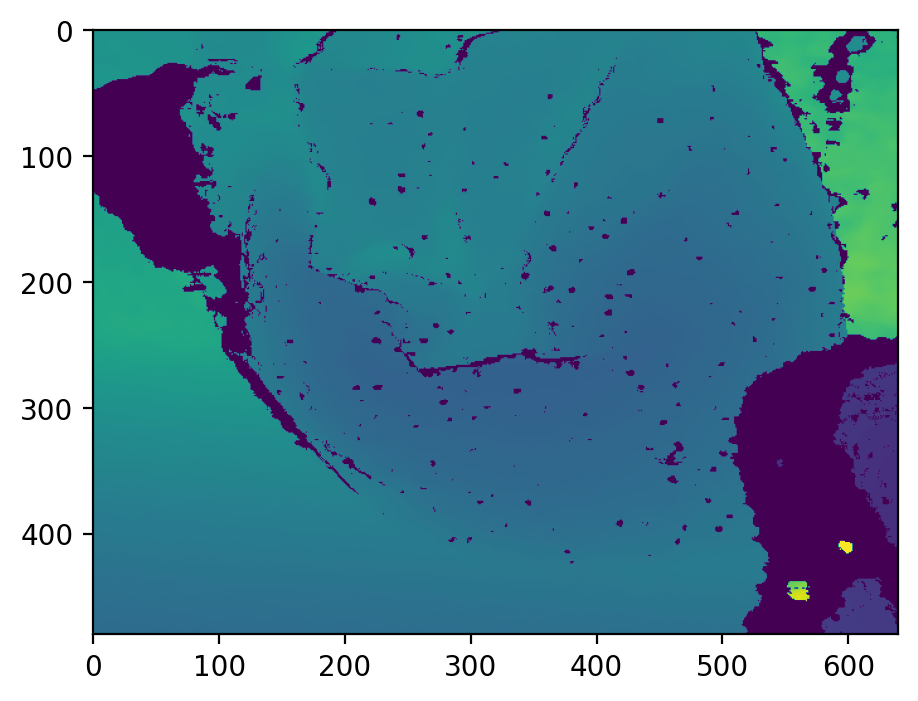

In [14]:
depth1, depth2 = map(partial(cv2.imread, flags=cv2.IMREAD_UNCHANGED), get_im_names([base_i, base_i2], depth=True))
plt.figure(dpi=200)
plt.imshow(depth1, vmax=2000)

# Going from 2d to 3d

In [74]:
def points_to_world_CS(points, depth_img):
    for x, y in points:
        depth = depth_img[int(y), int(x)]
        if depth > 4000 or depth < 100:
            yield [0,0,0]
        yield get_world_coords(x,y,depth)

def point_pairs_in_world_CS(point_pairs, depth_img1, depth_img2):
    points1 = points_to_world_CS((pair[0] for pair in point_pairs), depth_img1)
    points2 = points_to_world_CS((pair[1] for pair in point_pairs), depth_img2)
    for p1, p2 in zip(points1, points2):
        if max(p1) < 1 or max(p2) < 1:
            continue
        yield p1, p2


In [75]:
pp = point_pairs_in_world_CS(point_pairs, depth1, depth2)

In [78]:
pp = np.array(list(pp))
src = pp[:,0]
dst = pp[:,1]

In [79]:
len(pp)

73

# Displacement between frames

In [47]:
def rigid_transform_3D(A, B):
    # rigid transform algorithm from
    # http://nghiaho.com/?page_id=671
    assert len(A) == len(B)

    num_rows, num_cols = A.shape;

    if num_rows != 3:
        raise Exception("matrix A is not 3xN, it is {}x{}".format(num_rows, num_cols))

    [num_rows, num_cols] = B.shape;
    if num_rows != 3:
        raise Exception("matrix B is not 3xN, it is {}x{}".format(num_rows, num_cols))

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)
    # subtract mean
    Am = A - (np.repeat(centroid_A, (num_cols)).reshape((3,-1)))
    Bm = B - (np.repeat(centroid_B, (num_cols)).reshape((3,-1)))

    # dot is matrix multiplication for array
    H = np.dot(Am, np.transpose(Bm))

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
#         print("det(R) < R, reflection detected!, correcting for it ...\n");
        Vt[2,:] *= -1
        R = np.dot(Vt.T, U.T)

    t = -np.dot(R,centroid_A) + centroid_B

    return R, t

# Simple interface to calculate inliers
class Translation():
    def estimate(self, src,dst):
        R, t = rigid_transform_3D(src.T, dst.T)
        self.R = R
        self.t =t
        
    def residuals(self, src, dst):
        residuals = np.zeros((src.shape[0]))
        for i in range(src.shape[0]):
            diff =  np.dot(self.R, src[i])+self.t - dst[i]
            residuals[i] = np.linalg.norm(diff)
        return residuals
        
#ransac estimate
model_robust, inliers = ransac((src, dst), Translation, min_samples=3, residual_threshold=50, max_trials=500)

In [80]:
rigid_transform_3D(src.T, dst.T)

(array([[ 0.9812447 , -0.18705143,  0.04658969],
        [ 0.16853355,  0.94977602,  0.26367017],
        [-0.09356965, -0.25087303,  0.96348713]]),
 array([ -91.05754413, -211.75252929,  -17.86203763]))

In [49]:
model_robust.t

array([-4.46309677, 32.92591343,  6.12879448])

In [50]:
inliers

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False, False, False,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False,  True,
       False,  True, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False,  True, False, False, False, False,  True, False,
        True, False,  True, False, False, False, False, False, False,
       False])

In [51]:
def get_transform(i,j):
    img1, img2 = map(cv2.imread, get_im_names([i, j]))
    depth1, depth2 = map(partial(cv2.imread, flags=cv2.IMREAD_UNCHANGED), get_im_names([i, j], depth=True))
    point_pairs = list(get_pair_point(img1,img2))
    pp = point_pairs_in_world_CS(point_pairs, depth1, depth2)
    pp = np.array(list(pp))
    src = pp[:,0]
    dst = pp[:,1]
    model_robust, inliers = ransac((src, dst), Translation, min_samples=3, residual_threshold=40, max_trials=400)
    return model_robust



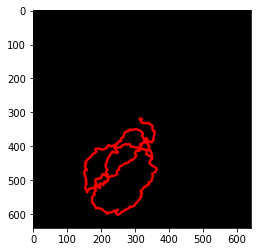

In [52]:
track = np.zeros((640,640,3))
start = np.array([320,320])
correct = np.eye(3)
j = 500
for i in range(500, 1030):
    if i == 740:
        continue
    a = (get_transform(j, i))
    delta = - a.t
    if np.linalg.norm(delta) > 200:
        continue
    else:
        j = i
    delta = np.dot(correct, delta)
    correct = np.dot(correct, a.R.T)

    end = start + delta[[0,2]]/10
    track = cv2.arrowedLine(track, (int(start[0]), int(start[1])), (int(end[0]), int(end[1])), (1,0,0), 5)
    start = end
plt.imshow(track)